In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

%matplotlib inline

# Load data and prepare baseline

In [17]:
import os
import scipy.signal
from tqdm.notebook import tqdm

In [3]:
folder_names = ["15312003", "15312011","15318006","15320003", "15519003", "15602007", "15611018", "15618010"]
distance = ["50 um", "50 um","65 um", "105 um", "40 um", "55 um", "135 um", "85 um"]
comp = ["comp_ON", "comp_OFF"]
t = np.linspace(-20000,20000,1999999)

In [10]:
T = 0.00002 # s
Fs = 1/T # Hz
print(Fs)

w = int(np.floor(Fs)) # window size for averaging is 1 sec


49999.99999999999


In [11]:
root_dir = "./"

In [18]:
dt = 0.02

soma_autocorrs = []
dend_autocorrs = []

# iterate through all folders
for name in tqdm(folder_names):
    data = np.loadtxt(os.path.join(root_dir, name, "comp_ON.txt"))

    n_samples = data.shape[0]
    print(f"\nWorking on {name}")
    print(f"Number of samples: {n_samples}")

    t = np.linspace(0, (n_samples-1)*dt, num=n_samples) # in ms

    data_soma = data[:,2]
    data_dend = data[:,1]

    # compute average sec. trend with convolution
    average_soma = np.convolve(data_soma, np.ones(w)/w, mode='same')
    average_dend = np.convolve(data_dend, np.ones(w)/w, mode='same')

    # remove average sec trend from data
    data_soma = data_soma - average_soma
    data_dend = data_dend - average_dend

    # replace trailing data with zeros to avoid edge effects
    data_soma[:w] = 0
    data_dend[:w] = 0
    data_soma[-w:] = 0
    data_dend[-w:] = 0

    # compute autocorrelation
    autocorr_soma = scipy.signal.correlate(data_soma, data_soma, mode="full")
    autocorr_dend = scipy.signal.correlate(data_dend, data_dend, mode="full")

    start_idx = (len(autocorr_soma)-1)//2

    # unbiased normalization
    lags = np.arange(-(n_samples-1), n_samples)
    autocorr_soma = autocorr_soma / (n_samples - np.abs(lags))
    autocorr_dend = autocorr_dend / (n_samples - np.abs(lags))

    soma_autocorrs.append(autocorr_soma[start_idx:])
    dend_autocorrs.append(autocorr_dend[start_idx:])


  0%|          | 0/8 [00:00<?, ?it/s]


Working on 15312003
Number of samples: 1000000

Working on 15312011
Number of samples: 1000000

Working on 15318006
Number of samples: 1000000

Working on 15320003
Number of samples: 1000000

Working on 15519003
Number of samples: 1000000

Working on 15602007
Number of samples: 1000000

Working on 15611018
Number of samples: 1000000

Working on 15618010
Number of samples: 1000000


In [19]:
# average autocorrs
soma_autocorrs = np.array(soma_autocorrs)
dend_autocorrs = np.array(dend_autocorrs)

soma_autocorrs_mean = np.mean(soma_autocorrs, axis=0)
dend_autocorrs_mean = np.mean(dend_autocorrs, axis=0)


In [26]:
# save data
np.savetxt(os.path.join(root_dir, "soma_autocorrs.txt"), soma_autocorrs)
np.savetxt(os.path.join(root_dir, "dend_autocorrs.txt"), dend_autocorrs)

<ipython-input-24-d866713d842a>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(t[:max_idx], soma_autocorrs_mean[:max_idx], color="r", lineWidth=2)


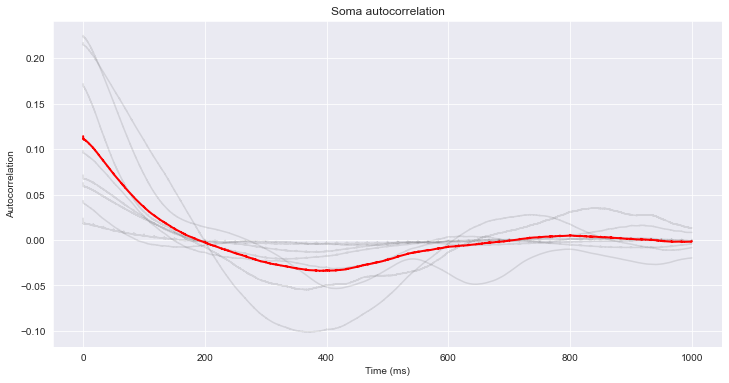

In [24]:
max_idx = int(1000/dt) # 1000 ms in index
# plot autocorrs
plt.figure(figsize=(12,6))
plt.plot(t[:max_idx], soma_autocorrs.T[:max_idx,:], color="k", alpha=0.1)
plt.plot(t[:max_idx], soma_autocorrs_mean[:max_idx], color="r", lineWidth=2)
plt.xlabel("Time (ms)")
plt.ylabel("Autocorrelation")
plt.title("Soma autocorrelation")
plt.show()

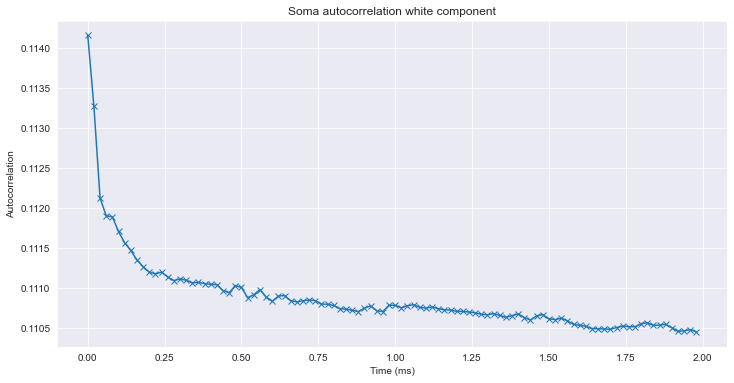

In [31]:
# plot autocorrs
plt.figure(figsize=(12,6))
plt.plot(t[:100], soma_autocorrs_mean[:100], '-x')
plt.xlabel("Time (ms)")
plt.ylabel("Autocorrelation")
plt.title("Soma autocorrelation white component")
plt.show()

In [32]:
A0 = soma_autocorrs_mean[0]
A1 = soma_autocorrs_mean[20]

print(f"Empirical autocorr amplitude: {A1}")
print(f"Additive white noise amplitude: {A0-A1}")

Empirical autocorr amplitude: 0.11104164107444242
Additive white noise amplitude: 0.003119017757827927


<ipython-input-25-55f13b0fed6f>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(t[:max_idx], dend_autocorrs_mean[:max_idx], color="r", lineWidth=2)


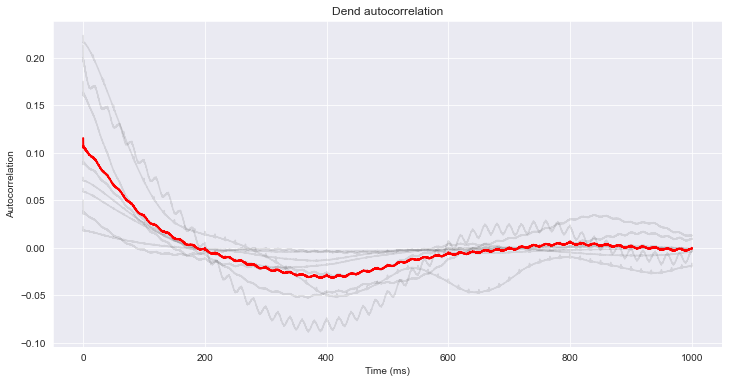

In [25]:
plt.figure(figsize=(12,6))
plt.plot(t[:max_idx], dend_autocorrs.T[:max_idx,:], color="k", alpha=0.1)
plt.plot(t[:max_idx], dend_autocorrs_mean[:max_idx], color="r", lineWidth=2)
plt.xlabel("Time (ms)")
plt.ylabel("Autocorrelation")
plt.title("Dend autocorrelation")
plt.show()

# Fit noise model to autocorrelation function

In [27]:
tb = t[:max_idx]
acrs_unb_m = soma_autocorrs_mean[:max_idx]

In [28]:
from scipy.optimize import curve_fit

def f1(t, A, T):
    return A*np.exp(-t/T)

def f2(t, A, T1, T2):
    return A*np.exp(-np.abs(t)/T1)*np.cos(2*np.pi/T2*np.abs(t))

p1_init = [0.025, 200]
p2_init = [0.025, 200, 600]

p1_opt, p1_cov = curve_fit(f1, tb, acrs_unb_m, p0=p1_init)
p1_err = np.sqrt(np.diag(p1_cov))
print("Optimized parameters f1: " + str(p1_opt))
print("Error of the fitting f1: " + str(p1_err))

p2_opt, p2_cov = curve_fit(f2, tb, acrs_unb_m, p0=p2_init)
p2_err = np.sqrt(np.diag(p2_cov))
print()
print("Optimized parameters f2: " + str(p2_opt))
print("Error of the fitting f2: " + str(p2_err))

Optimized parameters f1: [ 0.13686128 63.96370123]
Error of the fitting f1: [0.00056288 0.37201673]

Optimized parameters f2: [9.38860162e-02 3.22450267e+02 8.22919714e+02]
Error of the fitting f2: [1.22617243e-04 6.65998013e-01 5.22832242e-01]


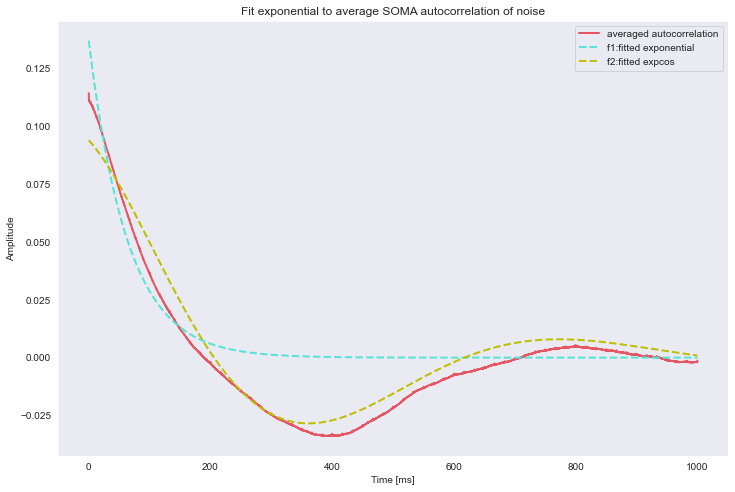

In [29]:
y = acrs_unb_m

plt.figure(figsize=(12,8))
plt.grid()
plt.title('Fit exponential to average SOMA autocorrelation of noise')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.plot(tb, y, label = "averaged autocorrelation", linewidth = 2, color = "#e45664", alpha = 1)
plt.plot(tb, f1(tb, *p1_opt), color='#56E4D6', linestyle="dashed", label = "f1:fitted exponential", linewidth = 2, alpha = 1)
plt.plot(tb, f2(tb, *p2_opt), color='y', linestyle="dashed", label = "f2:fitted expcos", linewidth = 2, alpha = 1)
plt.legend(loc="best")
plt.savefig("noise_model_fit_soma.pdf")
plt.show()

# Fit noise model to Dendrite autocorrelation function

In [34]:
acrs_unb_m = dend_autocorrs_mean[:max_idx]

In [35]:
from scipy.optimize import curve_fit

def f1(t, A, T):
    return A*np.exp(-t/T)

def f2(t, A, T1, T2):
    return A*np.exp(-np.abs(t)/T1)*np.cos(2*np.pi/T2*np.abs(t))

p1_init = [0.025, 200]
p2_init = [0.025, 200, 600]

p1_opt, p1_cov = curve_fit(f1, tb, acrs_unb_m, p0=p1_init)
p1_err = np.sqrt(np.diag(p1_cov))
print("Optimized parameters f1: " + str(p1_opt))
print("Error of the fitting f1: " + str(p1_err))

p2_opt, p2_cov = curve_fit(f2, tb, acrs_unb_m, p0=p2_init)
p2_err = np.sqrt(np.diag(p2_cov))
print()
print("Optimized parameters f2: " + str(p2_opt))
print("Error of the fitting f2: " + str(p2_err))

Optimized parameters f1: [ 0.12779079 63.12573839]
Error of the fitting f1: [0.00051126 0.35730047]

Optimized parameters f2: [8.71194583e-02 3.13537114e+02 8.22257026e+02]
Error of the fitting f2: [1.19249628e-04 6.80125058e-01 5.62849270e-01]


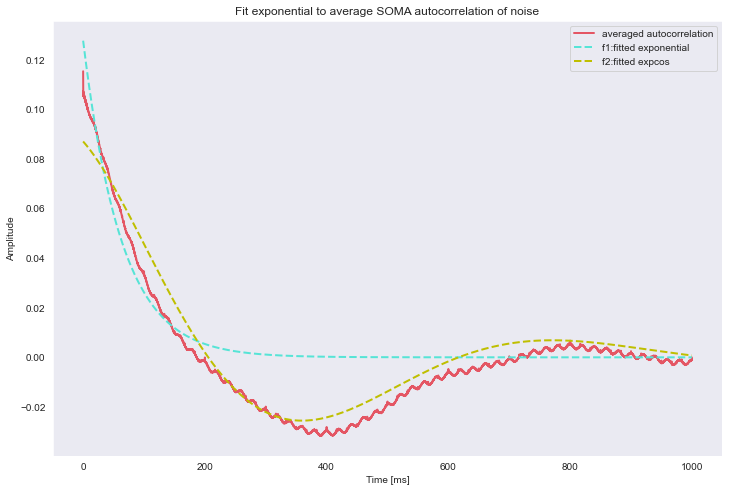

In [36]:
y = acrs_unb_m

plt.figure(figsize=(12,8))
plt.grid()
plt.title('Fit exponential to average SOMA autocorrelation of noise')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.plot(tb, y, label = "averaged autocorrelation", linewidth = 2, color = "#e45664", alpha = 1)
plt.plot(tb, f1(tb, *p1_opt), color='#56E4D6', linestyle="dashed", label = "f1:fitted exponential", linewidth = 2, alpha = 1)
plt.plot(tb, f2(tb, *p2_opt), color='y', linestyle="dashed", label = "f2:fitted expcos", linewidth = 2, alpha = 1)
plt.legend(loc="best")
plt.savefig("noise_model_fit_soma.pdf")
plt.show()